<a href="https://colab.research.google.com/github/stVan123/Deep-Learning-for-Tuberculosis-Prediction/blob/main/IMERI_KP_PROCESSING_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimpleITK==2.0.0

     |████████████████████████████████| 44.9 MB 1.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt 
import nibabel as nib 
import numpy as np 
import os 
import zipfile 
import cv2 
import SimpleITK as sitk 
import pandas as pd 
import glob
import random
import math

from PIL import Image 
from matplotlib.image import imread 
from google.colab.patches import cv2_imshow
from collections import Counter
from statistics import mean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SISA CODE

In [ ]:
#Menampilkan 1 gambar memakai library simple ITK

#import SimpleITK as sitk
#img = sitk.ReadImage("/content/drive/MyDrive/Rekapitulasi CXR Image Data/abnormal/39961540.nii") #read image
#plt.imshow(sitk.GetArrayFromImage(img), cmap=plt.cm.Greys_r) #plot image
#plt.axis("off")
#plt.show() 

In [ ]:
#Segmentasi menggunakan sitk pada nifti file

#seg = sitk.BinaryThreshold(
#img, lowerThreshold=160, upperThreshold=420, insideValue=1, outsideValue=0)
#otsu_filter = sitk.OtsuThresholdImageFilter()
#otsu_filter.SetInsideValue(1)
#otsu_filter.SetOutsideValue(0)
#seg = otsu_filter.Execute(img)

#overlay = sitk.LabelOverlay(img, seg)
#plt.imshow(sitk.GetArrayFromImage(overlay), cmap=plt.cm.Greys_r)

# MEMBACA PATH FOLDER

In [ ]:
#Path folder paru - paru normal abnormal dan segmentasinya
paru_abnormal = "/content/drive/MyDrive/Rekapitulasi CXR Image Data/Data/DATA ASLI/Abnormal"
paru_normal = "/content/drive/MyDrive/Rekapitulasi CXR Image Data/Data/DATA ASLI/Normal"
path_1 = "/content/drive/MyDrive/Rekapitulasi CXR Image Data/Segmentasi Paru - Paru/abnormal"
path_2 = "/content/drive/MyDrive/Rekapitulasi CXR Image Data/Segmentasi Paru - Paru/normal"


#mengambil file dalama list folder abnormal
img_ab = sorted([
    os.path.join(os.getcwd(), paru_abnormal, x)
    for x in os.listdir(paru_abnormal)
])

#mengambil file dalam list folder normal
img_n = sorted([
    os.path.join(os.getcwd(), paru_normal, x)
    for x in os.listdir(paru_normal)
])

#mengambil file dalam list folder segmentasi abnormal
img_seg_ab = sorted([
    os.path.join(os.getcwd(), path_1, x)
    for x in os.listdir(path_1)
])

#mengambil file dalam list folder segmentasi normal
img_seg_n = sorted([
    os.path.join(os.getcwd(),path_2, x)
    for x in os.listdir(path_2)
])

#Print banyak data yang ada di folder
print('Banyak data abnormal = ', len(img_ab))
print('Banyak data segmentasi abnormal = ', len(img_seg_ab))
print('Banyak data normal = ', len(img_n))
print('Banyak data segmentasi abnormal = ', len(img_seg_n))


#Melihat urutan nama file
#print(img_ab)
#print(img_seg_ab)
#print(img_n)

Banyak data abnormal =  55
Banyak data segmentasi abnormal =  55
Banyak data normal =  19
Banyak data segmentasi abnormal =  19


# MENGECEK KESESUAIN ID

In [ ]:
# Cek kesesuaian ID pada setiap grup data normal dan segmentasi normal

ncxr_ids = []
nseg_ids = []

for ncxr in img_n:
    ncxr_id = ncxr.split("/")[-1].split(".")[0]
    ncxr_ids.append(ncxr_id)

for nseg in img_seg_n:
    nseg_id = nseg.split("/")[-1].split(".")[0]
    nseg_ids.append(nseg_id)

print('normal')
print(len(ncxr_ids), ncxr_ids)
print(len(nseg_ids), nseg_ids)

# Cek kesesuaian ID pada setiap grup data abnormal dan segmentasi abnormal

acxr_ids = []
aseg_ids = []

for acxr in img_ab:
    acxr_id = acxr.split("/")[-1].split(".")[0]
    acxr_ids.append(acxr_id)

for aseg in img_seg_ab:
    aseg_id = aseg.split("/")[-1].split(".")[0]
    aseg_ids.append(aseg_id)

print("\n")

print('abnormal')
print(len(acxr_ids), acxr_ids)
print(len(aseg_ids), aseg_ids)


normal
19 ['38310610', '39123760', '39393880', '40143720', '40865630', '41411530', '41574600', '42146450', '42581430', '42725930', '44461810', '44473790', '44614390', '44615060', '44617450', '44618080', '44618580', '44618670', '44621760']
19 ['38310610', '39123760', '39393880', '40143720', '40865630', '41411530', '41574600', '42146450', '42581430', '42725930', '44461810', '44473790', '44614390', '44615060', '44617450', '44618080', '44618580', '44618670', '44621760']


abnormal
55 ['32081920', '32301310', '32967370', '34999600', '36764870', '36993100', '38160860', '39341110', '39961540', '40275370', '41558270', '42232070', '42449610', '42449610b', '42462530', '42586420', '43004830', '43018230', '43039300', '43120920', '43467410', '43544100', '43560020', '43619430', '43637780', '43717130', '43743780', '4381200', '43822410', '43873980', '43886210', '43919410', '43936220', '44134730', '44145760', '44188980', '44196050', '44198410', '44200650', '44229820', '44268430', '44287880', '44296820'

# PREPROCESSING IMAGE FUNCTION

In [ ]:
#mengubah rotasi image
def rotation(img):
    img = sitk.ReadImage(img)
    img = sitk.Cast(sitk.RescaleIntensity(img),sitk.sitkUInt8)
    img_array = sitk.GetArrayFromImage(img)
    if len(img_array.shape) == 3:
      img_transpose = np.transpose(img_array[0])
    else:
      img_transpose = np.transpose(img_array)
    rot_img = np.rot90(img_transpose)
    return rot_img

#grayscale image
def grayscale(lbl):
    lbl = sitk.ReadImage(lbl)
    lbl_array = sitk.GetArrayFromImage(lbl)
    gray_lbl = cv2.cvtColor(lbl_array, cv2.COLOR_BGR2GRAY)
    return gray_lbl

#get segmentasi data
def get_seg(seg):
    seg = sitk.ReadImage(seg)
    seg = sitk.Cast(sitk.RescaleIntensity(seg), sitk.sitkUInt8)
    seg_array = sitk.GetArrayFromImage(seg)
    seg_img = seg_array[0]
    return seg_img

#resample jadi 512 x 512 
def resample_image(itk_image, out_size=[512, 512], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_spacing = [
        original_spacing[0] * (original_size[0] / out_size[0]),
        original_spacing[1] * (original_size[1] / out_size[1])
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image) 

In [ ]:
#print(fix_ab[3].GetSize())
#plt.imshow(sitk.GetArrayFromImage(fix_ab[3]), cmap=plt.cm.Greys_r)
#plt.axis("off")
#type(fix_ab[3])

MENCOBA VISUALISASI 1 GAMBAR

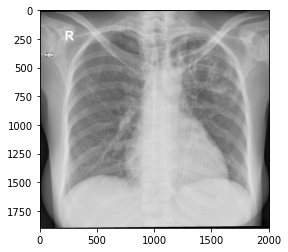

In [ ]:
#Pada data abnormal 2
img = rotation(img_ab[1])
plt.imshow(img,cmap=plt.cm.Greys_r)

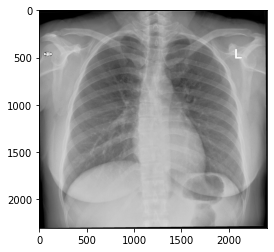

In [ ]:
#Pada data normal 0
img = rotation(img_n[0])
plt.imshow(img,cmap=plt.cm.Greys_r)

# MASKING CXR DAN SEGMENTASI

In [ ]:
#Memasukkan data normal yang telah dirotasi pada list
list_img_normal = []
list_seg_normal = []

#memasukkan data masking normal pada list
list_mask_normal = []

#pada data normal
for n, seg in zip(img_n,img_seg_n):
  img_normal = rotation(n)
  list_img_normal.append(img_normal)

  seg_normal = get_seg(seg)
  list_seg_normal.append(seg_normal)

  result_mask = cv2.bitwise_and(img_normal, seg_normal) #cv2.bitwise untuk membuat masking antara data abnormal dan segmentasinya
  list_mask_normal.append(result_mask)

In [ ]:
#Memasukkan data abnormal yang telah dirotasi pada list
list_img_abnormal = []
list_seg_abnormal = []

#memasukkan data masking abnormal pada list
list_mask_abnormal = []

#pada data abnormal
for ab, seg in zip(img_ab,img_seg_ab):
  img_abnormal = rotation(ab)
  list_img_abnormal.append(img_abnormal)

  seg_abnormal = get_seg(seg)
  list_seg_abnormal.append(seg_abnormal)

  result_mask = cv2.bitwise_and(img_abnormal, seg_abnormal) #cv2.bitwise untuk membuat masking antara data abnormal dan segmentasinya
  list_mask_abnormal.append(result_mask)

Mencoba pada hasil masking `Data Normal`

(-0.5, 2409.5, 2299.5, -0.5)

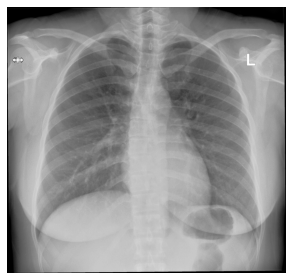

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(list_img_normal[0], cmap=plt.cm.Greys_r)
plt.axis("off")

(-0.5, 2409.5, 2299.5, -0.5)

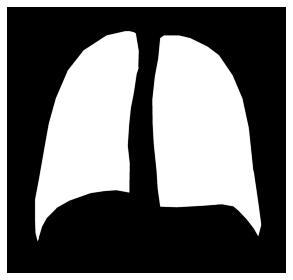

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(list_seg_normal[0], cmap=plt.cm.Greys_r)
plt.axis("off")

(-0.5, 2409.5, 2299.5, -0.5)

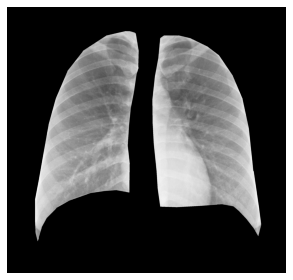

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(list_mask_normal[0], cmap=plt.cm.Greys_r)
plt.axis("off")

Mencoba hasil masking pada `Data Abnormal`

(-0.5, 2427.5, 2360.5, -0.5)

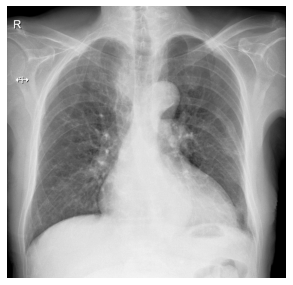

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(list_img_abnormal[8], cmap=plt.cm.Greys_r)
plt.axis("off")

(-0.5, 2427.5, 2360.5, -0.5)

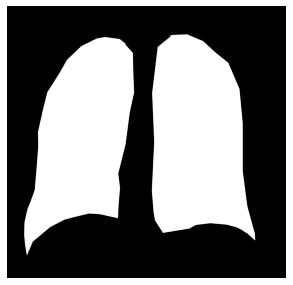

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(list_seg_abnormal[8], cmap=plt.cm.Greys_r)
plt.axis("off")

(-0.5, 2427.5, 2360.5, -0.5)

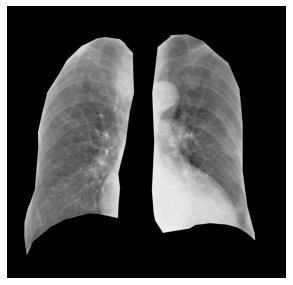

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(list_mask_abnormal[8], cmap=plt.cm.Greys_r)
plt.axis("off")

# GRID VISUALISASI

In [ ]:
def plot_slices(cxrs, seg, mask, ids, name):
    """Plot a montage of 20 CT slices"""

    heights = [slc.GetSize()[0] for slc in cxrs]
    width_cxrs = [slc.GetSize()[1] for slc in cxrs]
    width_anom = [slc.GetSize()[1] for slc in seg]
    width_ovl = [slc.GetSize()[1] for slc in mask]
    widths = [mean(width_cxrs), mean(width_anom), mean(width_ovl)]
    fig_height = 5.0
    fig_width = fig_height * sum(heights) / sum(widths)

    rows_data, columns_data = len(widths), len(heights)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
    )
    for j in range(columns_data):
        axarr[0, j].imshow(sitk.GetArrayFromImage(cxrs[j]), cmap="gray")
        axarr[0, j].set_title(f"{ids[j]}\n{name[j]}")
        axarr[0, j].axis("off")
        axarr[1, j].imshow(sitk.GetArrayFromImage(seg[j]), cmap="gray")
        axarr[1, j].axis("off")
        axarr[2, j].imshow(sitk.GetArrayFromImage(mask[j]), cmap="gray")
        axarr[2, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

PLOT SLICES DATA ABNORMAL DAN NORMAL

Mengubah data rotate menjadi resample 512 x 512 `pada data normal`

In [ ]:
res_ncxrs = []
res_nmasks = []
res_nsegs = []

#Mengubah data list yang telah dirotate menjadi resample 512 x 512

for p in list_img_abnormal: #Pada data abnormal
  res_ncxr = resample_image(sitk.GetImageFromArray(p))
  res_ncxrs.append(res_ncxr)

for q in list_seg_abnormal: #Pada data segmentasi abnormal
  res_nseg = resample_image(sitk.GetImageFromArray(q))
  res_nsegs.append(res_nseg)

for r in list_mask_abnormal: #Pada data masking abnormal
  res_nmask = resample_image(sitk.GetImageFromArray(r))
  res_nmasks.append(res_nmask)

Mengubah data rotate menjadi resample 512 x 512 `pada data abnormal`

In [ ]:
res_acxrs = []
res_asegs = []
res_amasks = []

#Mengubah data list yang telah dirotate menjadi resample 512 x 512

for p in list_img_normal: #Pada data abnormal
  res_acxr = resample_image(sitk.GetImageFromArray(p))
  res_acxrs.append(res_acxr)

for q in list_seg_normal: #Pada data segmentasi abnormal
  res_aseg = resample_image(sitk.GetImageFromArray(q))
  res_asegs.append(res_aseg)

for r in list_mask_normal: #Pada data masking abnormal
  res_amask = resample_image(sitk.GetImageFromArray(r))
  res_amasks.append(res_amask)

`PLOT SLICES ABNORMAL`

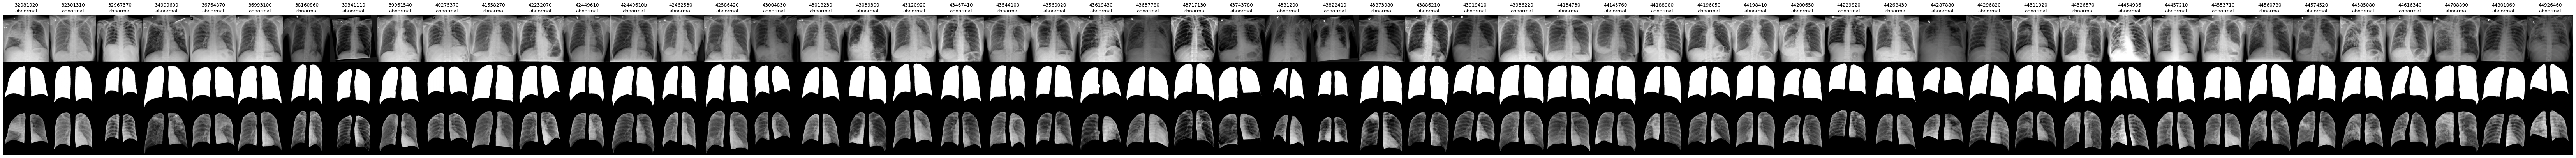

In [ ]:
name_norm = ["abnormal"]*len(res_ncxrs)
plot_slices(res_ncxrs, res_nsegs, res_nmasks, acxr_ids, name_norm)

`PLOT SLICES NORMAL`

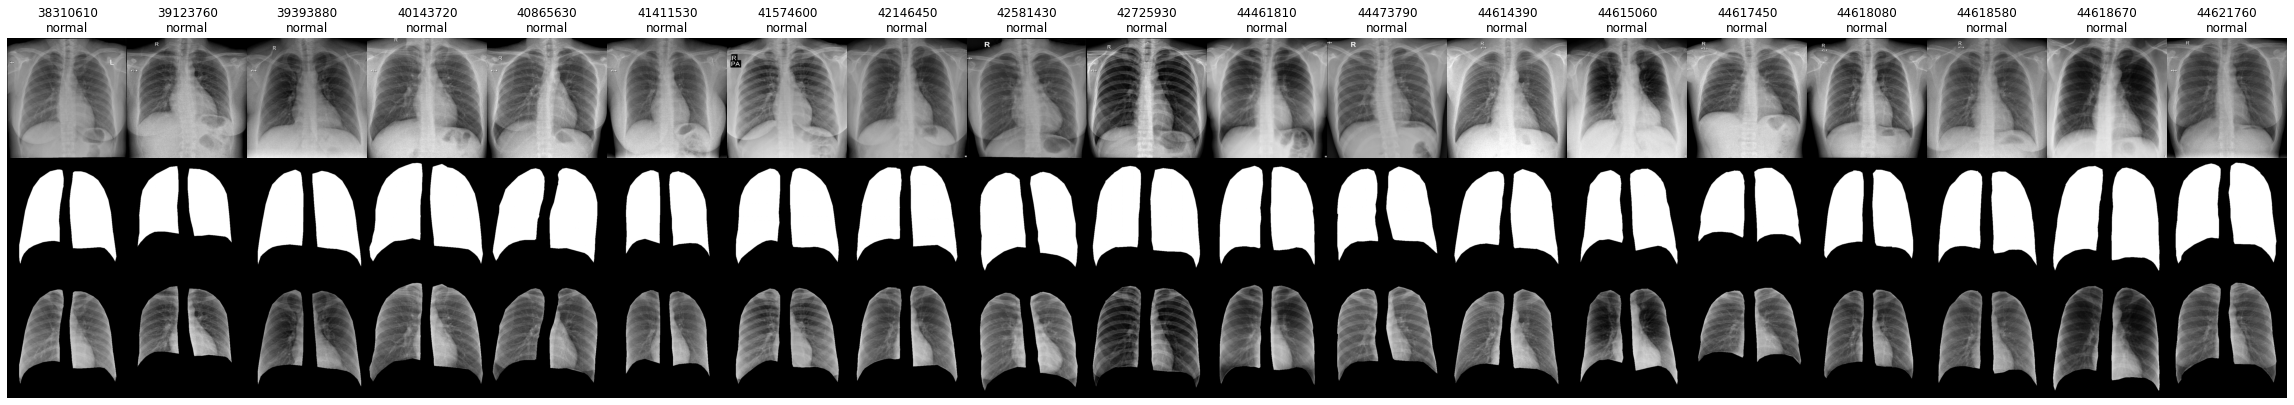

In [ ]:
name_norm = ["normal"]*len(res_acxrs)
plot_slices(res_acxrs, res_asegs, res_amasks, ncxr_ids, name_norm)

# MENGUBAH `70 DATA` ABNORMAL DAN NORMAL MENJADI `PNG`

RESIZE IMAGE SESUAI NOTEBOOK 128 X 128

In [ ]:
def resample_images(itk_image, out_size=[128, 128], is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_spacing = [
        original_spacing[0] * (original_size[0] / out_size[0]),
        original_spacing[1] * (original_size[1] / out_size[1])
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image) 

In [ ]:
# ncxr_ids untuk data normal
# acxr_ids untuk data abnormal
# list_img_normal
# list_img_abnormal

#Untuk save data abnormal
for a,b in zip(list_img_abnormal,acxr_ids):
    #resample_image menjadi 128 x 128
    imgs = resample_images(sitk.GetImageFromArray(a)) #Resize image 128 x 128
    lbl_array = sitk.GetArrayFromImage(imgs)
    #memakai PIL untuk save png
    im = Image.fromarray(lbl_array)
    im.save('/content/drive/MyDrive/Rekapitulasi CXR Image Data/Data/Abnormal_Normal/'+ b + '.png')

#Untuk save data normal
for c,d in zip(list_img_normal,ncxr_ids):
    #resample image menjadi 128 x 128
    imgs = resample_images(sitk.GetImageFromArray(c)) #Resize image 128 x 128
    lbl_array = sitk.GetArrayFromImage(imgs)
    #memakai PIL untuk save png
    im = Image.fromarray(lbl_array)
    im.save('/content/drive/MyDrive/Rekapitulasi CXR Image Data/Data/Abnormal_Normal/'+ d + '.png')

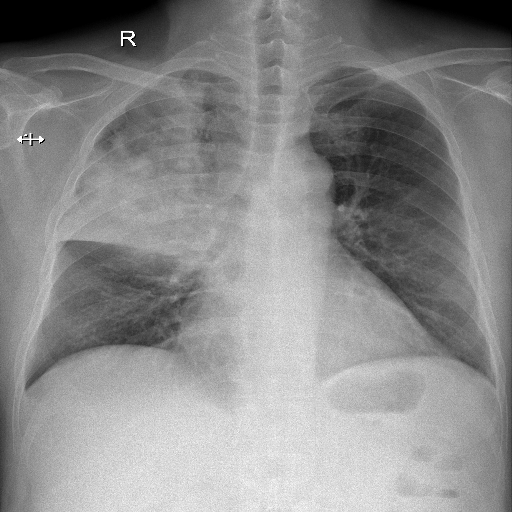

Size Data: (512, 512, 3)
Banyak Data: 74


In [ ]:
#test untuk melihat data udh masuk belum dan melihat ukurannya

paru_png = '/content/drive/MyDrive/Rekapitulasi CXR Image Data/Data/Abnormal_Normal'

img_aba = sorted([
    os.path.join(os.getcwd(), paru_png, x)
    for x in os.listdir(paru_png)
])

#meihat ukuran size bener apa tidak
img = cv2.imread(img_aba[0])
cv2_imshow(img)
print("Size Data:",img.shape)
print("Banyak Data:",len(img_aba))

Dilihat dari hasil diatas image telah diubah menjadi 128 x 128

# MEMBUAT CSV FILE

In [ ]:
#Membuat file csv pada data IMERI

#List untuk nama file
nama_file = []

for a in ncxr_ids:
  nama_normal = a + ".png"
  nama_file.append(nama_normal)

for b in acxr_ids:
  nama_abnormal = b + ".png"
  nama_file.append(nama_abnormal)

#List untuk label file
label_file = []

for a in range(len(ncxr_ids)):
  label_file.append('No Finding')
for b in range(len(acxr_ids)):
  label_file.append('TB')

#Membuat file csv
dict = {'Image Index': nama_file,'Finding Labels': label_file}
df = pd.DataFrame(dict)

df.to_csv('/content/drive/MyDrive/Rekapitulasi CXR Image Data/Data/sample_labels.csv') #save file ke csv

#Melihat hasil
print("Banyak Data nama_file:",len(nama_file))
print(nama_file, "\n")
print("Banyak data label_file:", len(label_file))
print(label_file)

Banyak Data nama_file: 74
['38310610.png', '39123760.png', '39393880.png', '40143720.png', '40865630.png', '41411530.png', '41574600.png', '42146450.png', '42581430.png', '42725930.png', '44461810.png', '44473790.png', '44614390.png', '44615060.png', '44617450.png', '44618080.png', '44618580.png', '44618670.png', '44621760.png', '32081920.png', '32301310.png', '32967370.png', '34999600.png', '36764870.png', '36993100.png', '38160860.png', '39341110.png', '39961540.png', '40275370.png', '41558270.png', '42232070.png', '42449610.png', '42449610b.png', '42462530.png', '42586420.png', '43004830.png', '43018230.png', '43039300.png', '43120920.png', '43467410.png', '43544100.png', '43560020.png', '43619430.png', '43637780.png', '43717130.png', '43743780.png', '4381200.png', '43822410.png', '43873980.png', '43886210.png', '43919410.png', '43936220.png', '44134730.png', '44145760.png', '44188980.png', '44196050.png', '44198410.png', '44200650.png', '44229820.png', '44268430.png', '44287880.png